<a href="https://colab.research.google.com/github/tyrypic/python-pil-labworks/blob/main/variant2_lab3_perlik_k_4_101_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №3: «Гистограмма и преобразование интенсивностей полутоновых изображений»
**Вариант 2**

**Цель:** Освоить способы трансформации изображения попиксельной обработкой и использование гистограмм.

**Задание:**
1. Возьмите полученную в 1-й лабораторной работе картинку и переведите её в grayscale-режим  
   (Y = 0.2126·R + 0.7152·G + 0.0722·B), далее используйте это полутоновое изображение вместе с тремя другими полутоновыми картинками.
2. Постройте гистограммы всех изображений.
3. Выполните логарифмическое преобразование изображений, постройте гистограммы результатов.
4. Выполните степенные (гамма) преобразования изображений, постройте гистограммы результатов.
5. Реализуйте кусочно-линейные преобразования с двумя разными наборами параметров, постройте гистограммы.
6. Выполните пороговую сегментацию для многопиковых гистограмм, локализуйте отдельные объекты и покажите результаты.

*Исходные файлы разместите в папке `images/`, результаты будете сохранять в `output/`.*

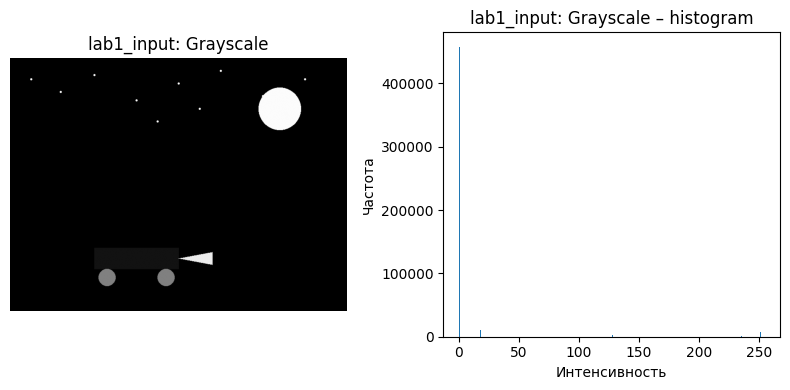

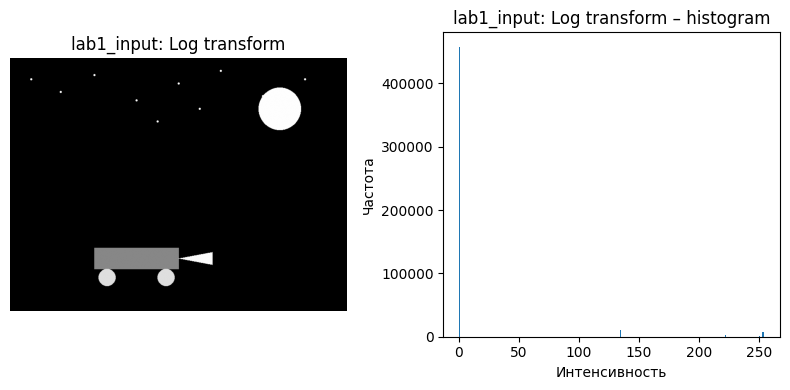

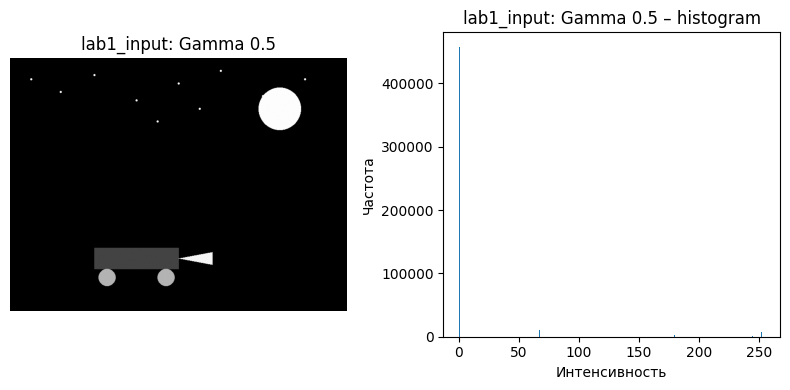

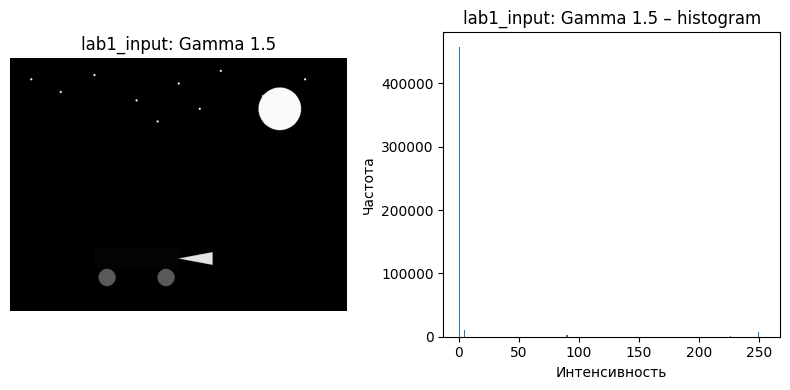

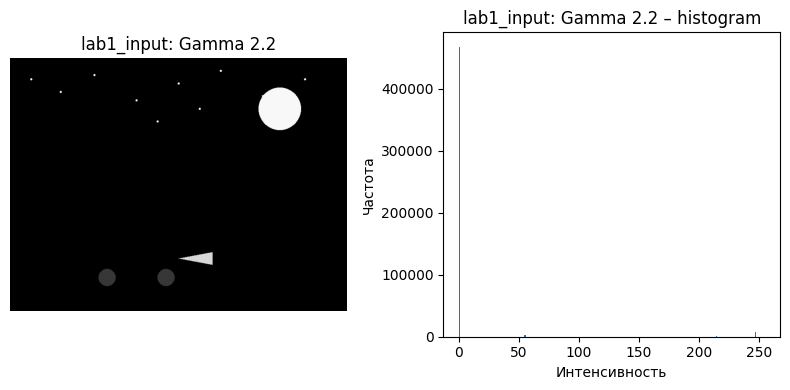

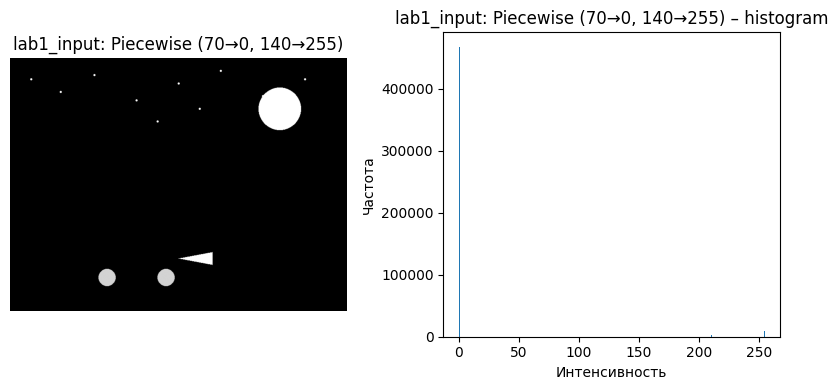

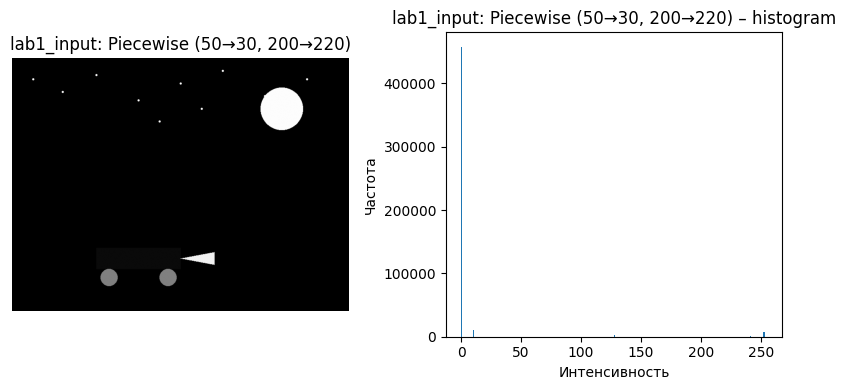

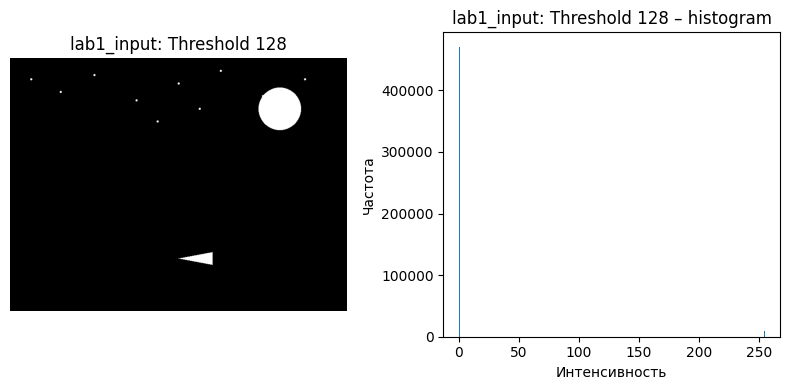

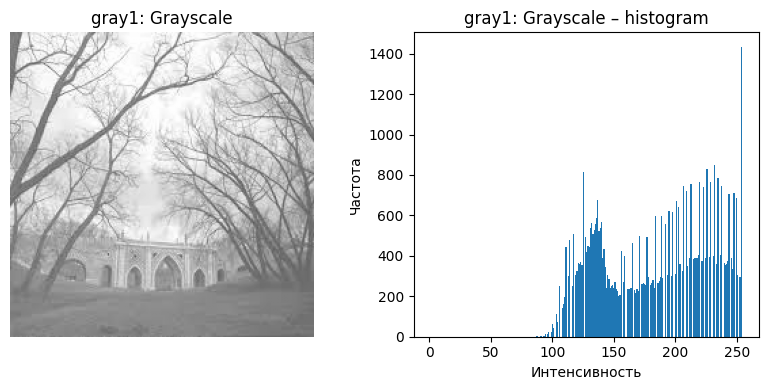

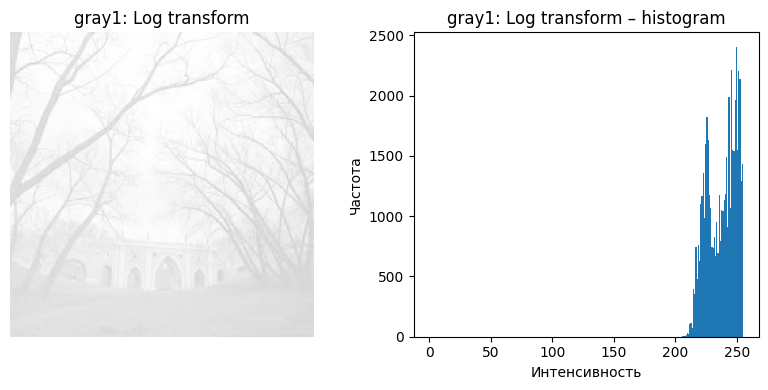

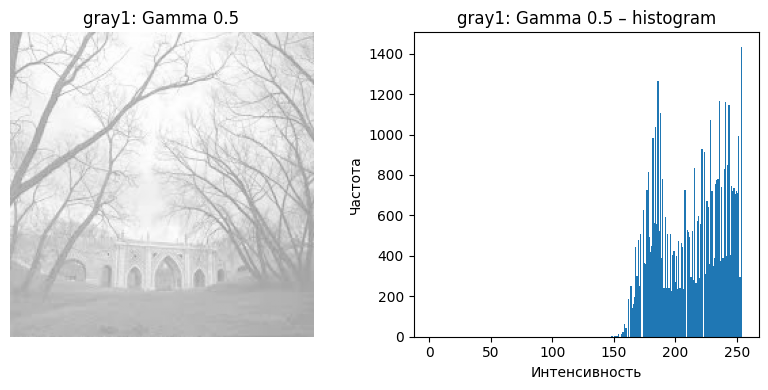

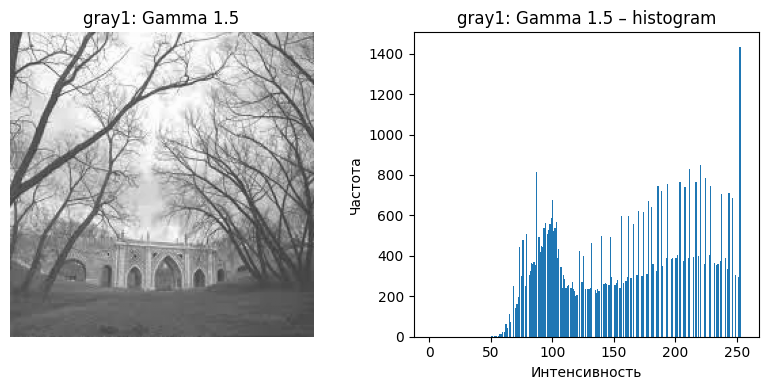

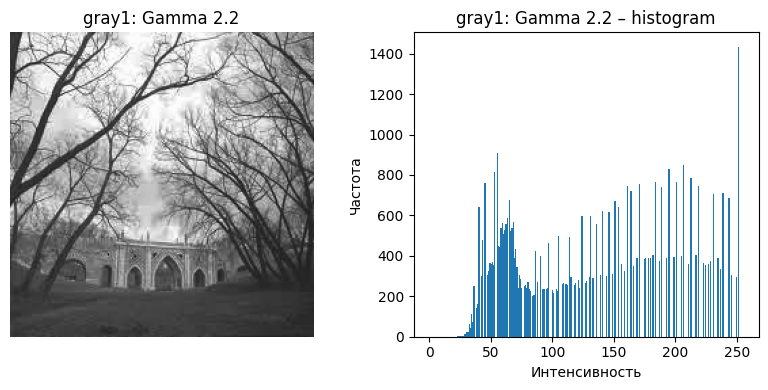

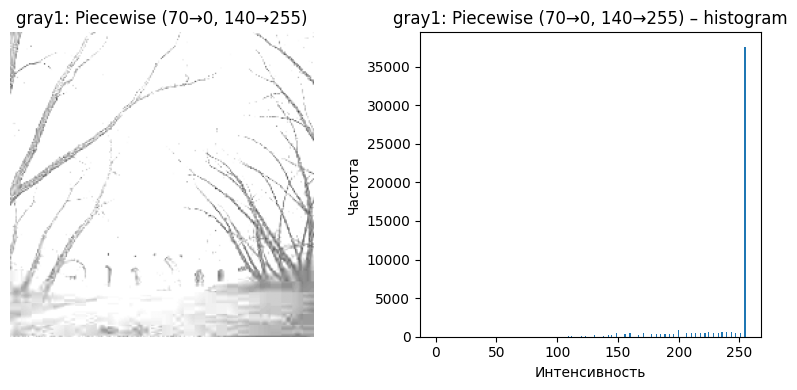

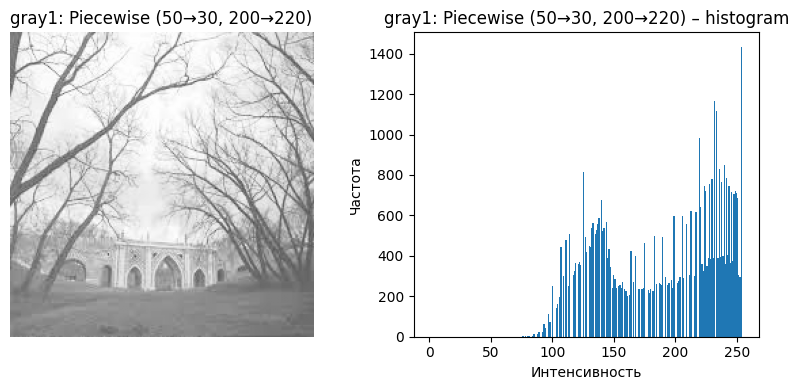

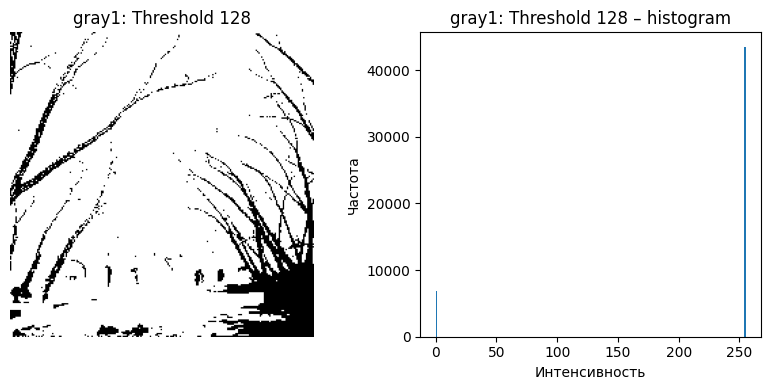

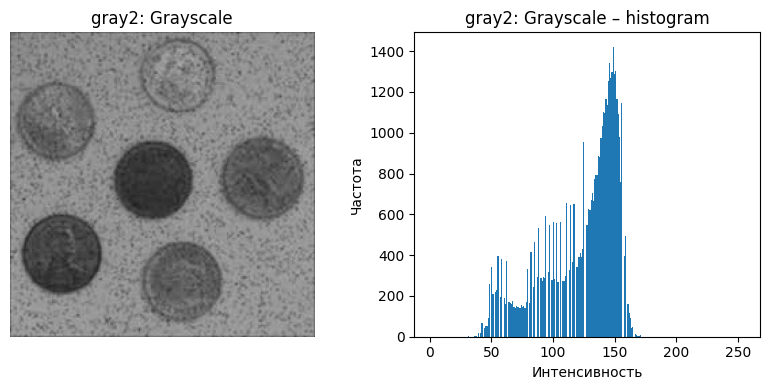

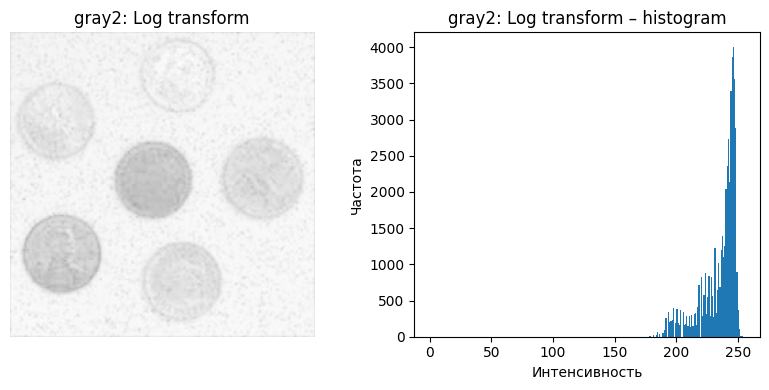

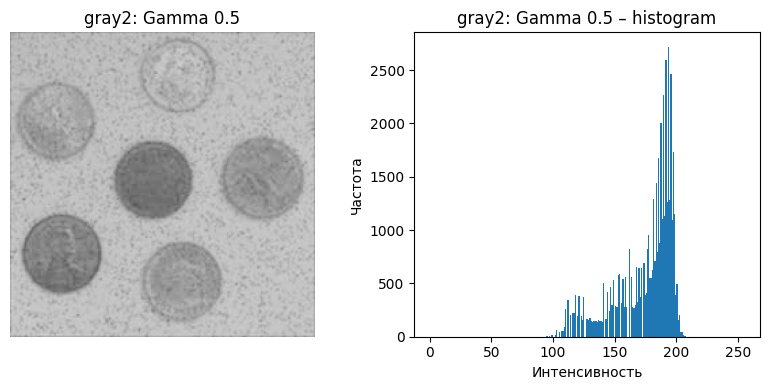

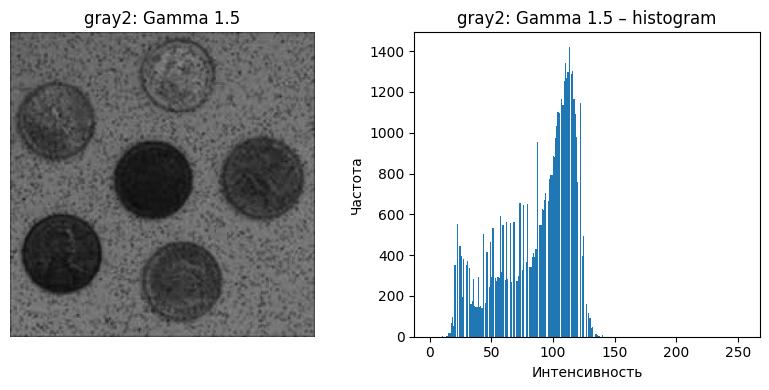

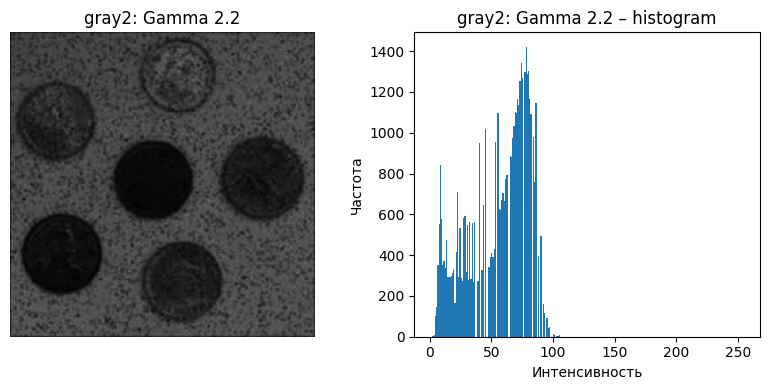

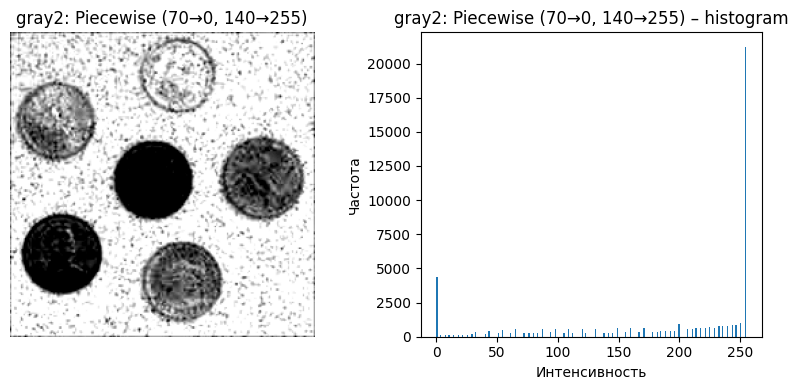

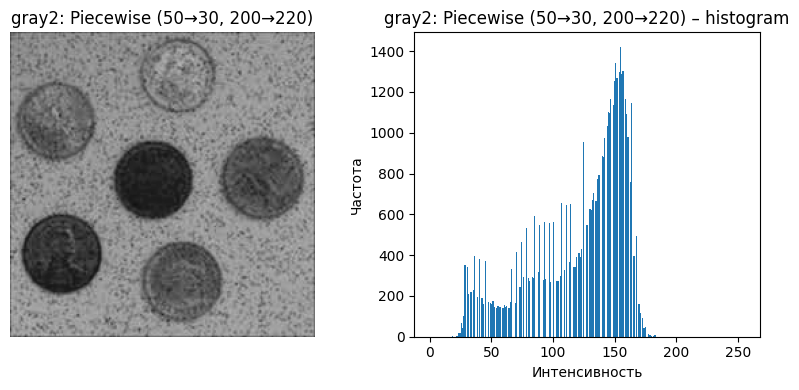

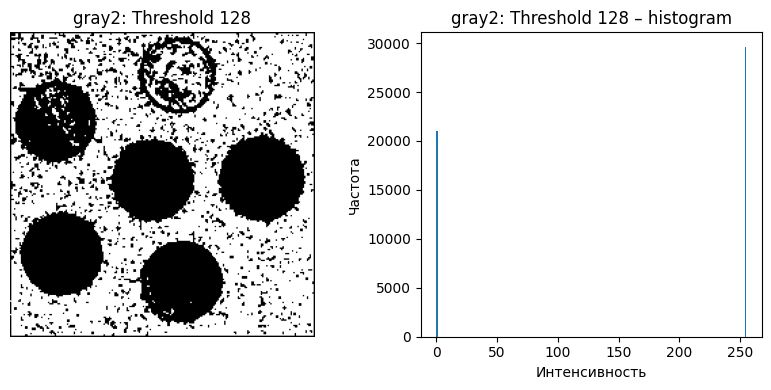

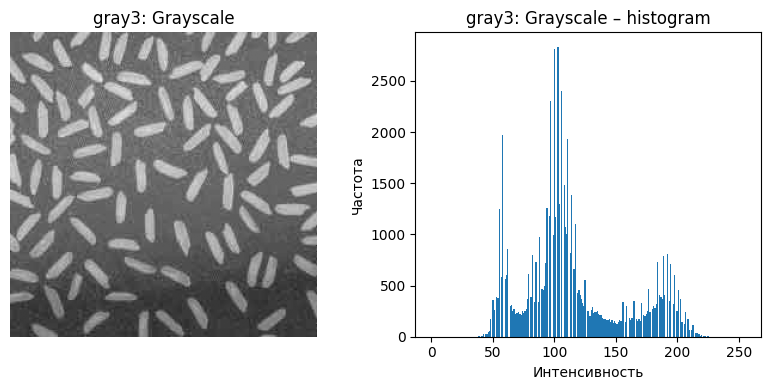

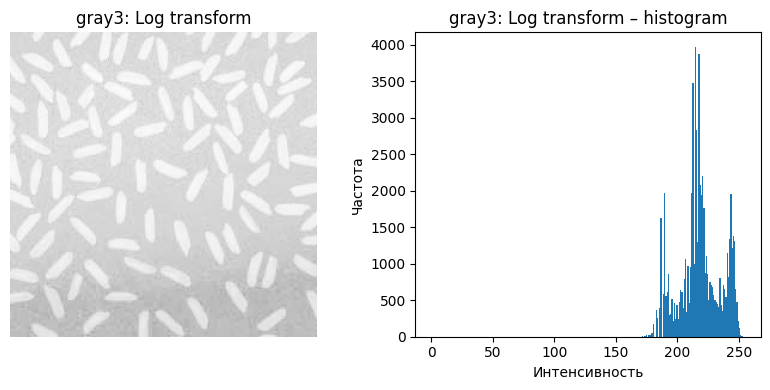

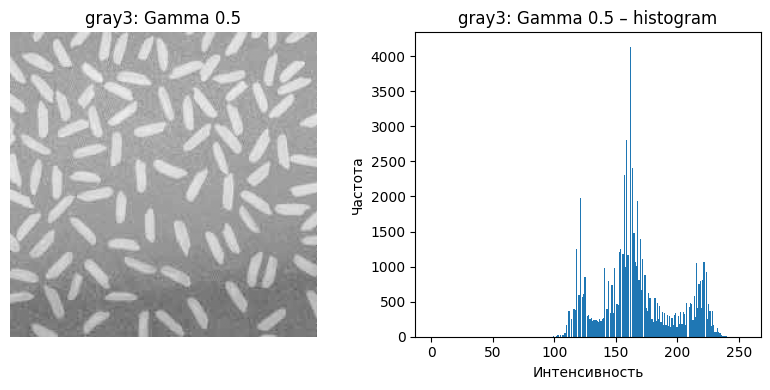

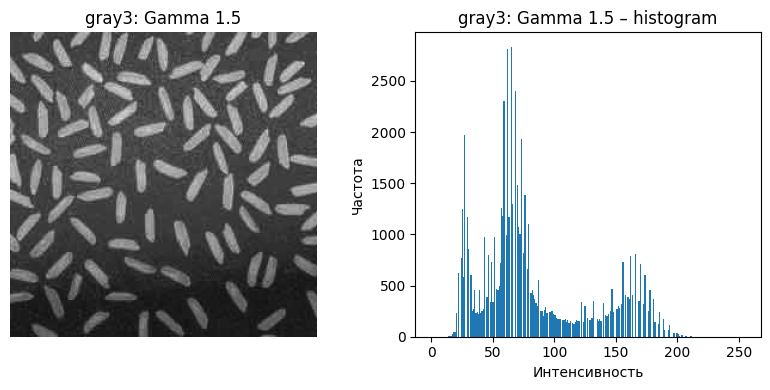

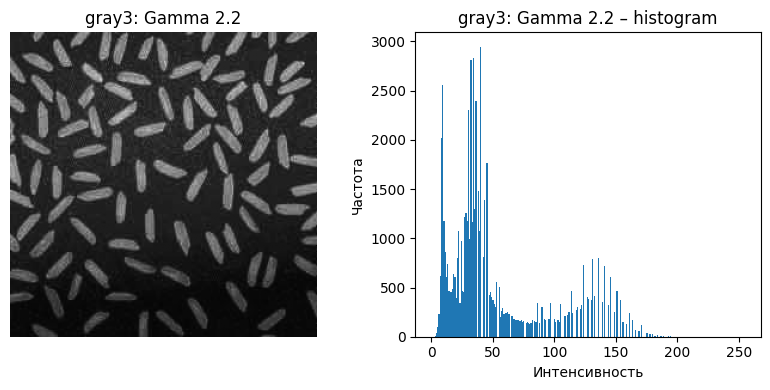

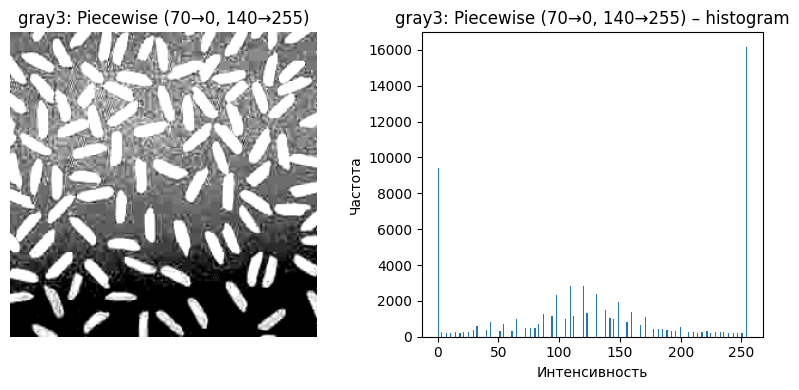

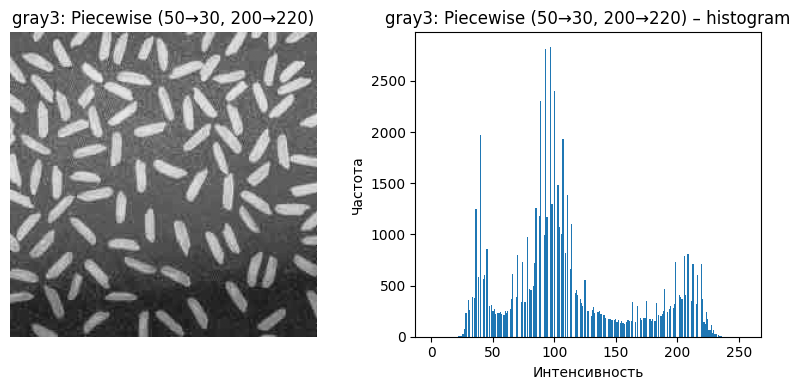

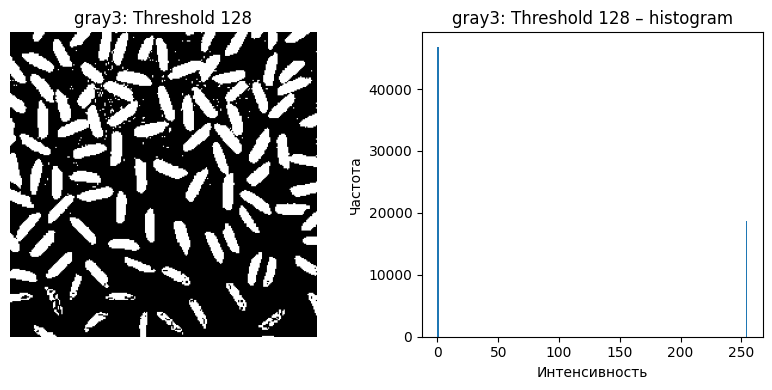

In [ ]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Пути к исходным изображениям
image_paths = [
    'images/lab1_input.png',
    'images/gray1.jpg',
    'images/gray2.jpg',
    'images/gray3.jpg'
]

# Вспомогательная функция: показать изображение и его гистограмму
def show_with_hist(img, title):
    arr = np.array(img if not isinstance(img, np.ndarray) else Image.fromarray(img))
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
    plt.title(title)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.hist(arr.ravel(), bins=256, range=(0,255))
    plt.title(f'{title} – histogram')
    plt.xlabel('Интенсивность')
    plt.ylabel('Частота')
    plt.tight_layout()
    plt.show()

# Преобразования из вашей ЛР-3
def rgb_to_gray(image):
    arr = np.array(image).astype(float)
    y = 0.2126*arr[...,0] + 0.7152*arr[...,1] + 0.0722*arr[...,2]
    return Image.fromarray(np.uint8(y))

def log_transform(image):
    arr = np.array(image).astype(float)
    c = 255 / np.log(1 + arr.max())
    out = np.uint8(np.clip(c * np.log(1 + arr), 0, 255))
    return Image.fromarray(out)

def power_law_transform(image, gamma):
    arr = np.array(image).astype(float) / 255.0
    out = np.uint8(np.clip((arr**gamma)*255, 0, 255))
    return Image.fromarray(out)

def piecewise_linear(image, r1, s1, r2, s2):
    arr = np.array(image).astype(float)
    out = np.zeros_like(arr)
    # участок 1
    mask1 = arr <= r1
    out[mask1] = (s1/r1) * arr[mask1]
    # участок 2
    mask2 = (arr > r1) & (arr <= r2)
    out[mask2] = ((s2-s1)/(r2-r1))*(arr[mask2]-r1) + s1
    # участок 3
    mask3 = arr > r2
    out[mask3] = ((255-s2)/(255-r2))*(arr[mask3]-r2) + s2
    return Image.fromarray(np.uint8(np.clip(out,0,255)))

def threshold_segmentation(image, thresh):
    arr = np.array(image)
    seg = np.where(arr > thresh, 255, 0).astype(np.uint8)
    return Image.fromarray(seg)

# Выполняем по каждой картинке
for path in image_paths:
    img = Image.open(path).convert('RGB')
    base = os.path.splitext(os.path.basename(path))[0]

    # 1. Полутоновое
    gray = rgb_to_gray(img)
    show_with_hist(gray, f'{base}: Grayscale')

    # 3. Логарифмическое
    log_img = log_transform(gray)
    show_with_hist(log_img, f'{base}: Log transform')

    # 4. Гамма-преобразования
    for g in [0.5, 1.5, 2.2]:
        gamma_img = power_law_transform(gray, g)
        show_with_hist(gamma_img, f'{base}: Gamma {g}')

    # 5. Кусочно-линейные (два набора)
    pw1 = piecewise_linear(gray, r1=70, s1=0,   r2=140, s2=255)
    show_with_hist(pw1, f'{base}: Piecewise (70→0, 140→255)')
    pw2 = piecewise_linear(gray, r1=50, s1=30,  r2=200, s2=220)
    show_with_hist(pw2, f'{base}: Piecewise (50→30, 200→220)')

    # 6. Пороговая сегментация
    thresh = 128
    seg = threshold_segmentation(gray, thresh)
    show_with_hist(seg, f'{base}: Threshold {thresh}')


## Лабораторная № 3: «Гистограмма и преобразования интенсивностей»

1. **Гистограмма**
   Гистограмма показывает распределение яркости — сколько пикселей каждого уровня (0…255). Анализ гистограмм позволяет выявить, есть ли на изображении «спайки» (много пикселей одного уровня), однородные области или широкое покрытие.

2. **Логарифмическое преобразование**
   Формула

   $$
     s = c \cdot \log(1 + r)
   $$

   где r — входная яркость, c — масштабный коэффициент. Это сжимает тёмные тона (многие маленькие значения r растягиваются), и сжимает яркие более сильно. Полезно, когда на изображении много тёмных деталей, которые «спрессованы» в нижних уровнях.

3. **Гамма-преобразование**

   $$
     s = r^\gamma
   $$

   дозирует яркость: при γ<1 осветляет изображение (растягивает тёмные), при γ>1 — затемняет (сжимает светлые). Часто используется для коррекции отображения на экранах.

4. **Кусочно-линейное преобразование**
   Разбивает карту яркости на три участка:

   * до r₁ — линейно растягивает к s₁;
   * между r₁ и r₂ — к промежуточному диапазону s₁…s₂;
   * выше r₂ — растягивает в область s₂…255.
     Позволяет усилить контраст в выбранном сегменте яркостей и подавить нежелательные диапазоны.

5. **Пороговая сегментация для многопиковых гистограмм**
   Если гистограмма имеет несколько чётких пиков (фон, средние объекты, яркие блики), можно подобрать несколько порогов, чтобы отделить объекты разных яркостей. Это упрощает последующую обработку (например, подсчёт или анализ форм).